# Import Libs #

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import logging
import glob
import random
import warnings
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms, models
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from PIL import Image
from torch.cuda.amp import autocast, GradScaler
from typing import Dict, List, Tuple, Optional, Union
warnings.filterwarnings('ignore')

# Set Up #

In [2]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('face_recognition.log')
    ]
)
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [3]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")
if torch.cuda.is_available():
    logger.info(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        logger.info(f"GPU {i}: {torch.cuda.get_device_name(i)}")

In [4]:
print(device)
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

cuda
Number of GPUs: 2
GPU 0: Tesla T4
GPU 1: Tesla T4


# Read Dataset #

In [5]:
# Define paths
train_path ="/kaggle/input/rmfd-dataset/self-built-masked-face-recognition-dataset/AFDB_face_dataset"
test_path = "/kaggle/input/rmfd-dataset/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset"

## Train Dataset ##

In [6]:
train = []
for path in glob.iglob(os.path.join(train_path, "**", "*.jpg")):
    person = path.split("/")[-2]
    train.append({"person":person, "path": path})
    
train = pd.DataFrame(train)
train = train.groupby("person").filter(lambda x: len(x) > 5)
train.head(10)

,person,path
0,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...
1,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...
2,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...
3,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...
4,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...
5,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...
6,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...
7,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...
8,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...
9,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...


In [7]:
train.describe

<bound method NDFrame.describe of             person                                               path
0         masichun  /kaggle/input/rmfd-dataset/self-built-masked-f...
1         masichun  /kaggle/input/rmfd-dataset/self-built-masked-f...
2         masichun  /kaggle/input/rmfd-dataset/self-built-masked-f...
3         masichun  /kaggle/input/rmfd-dataset/self-built-masked-f...
4         masichun  /kaggle/input/rmfd-dataset/self-built-masked-f...
...            ...                                                ...
90463  chendouling  /kaggle/input/rmfd-dataset/self-built-masked-f...
90464  chendouling  /kaggle/input/rmfd-dataset/self-built-masked-f...
90465  chendouling  /kaggle/input/rmfd-dataset/self-built-masked-f...
90466  chendouling  /kaggle/input/rmfd-dataset/self-built-masked-f...
90467  chendouling  /kaggle/input/rmfd-dataset/self-built-masked-f...

[90468 rows x 2 columns]>

<Axes: xlabel='person'>

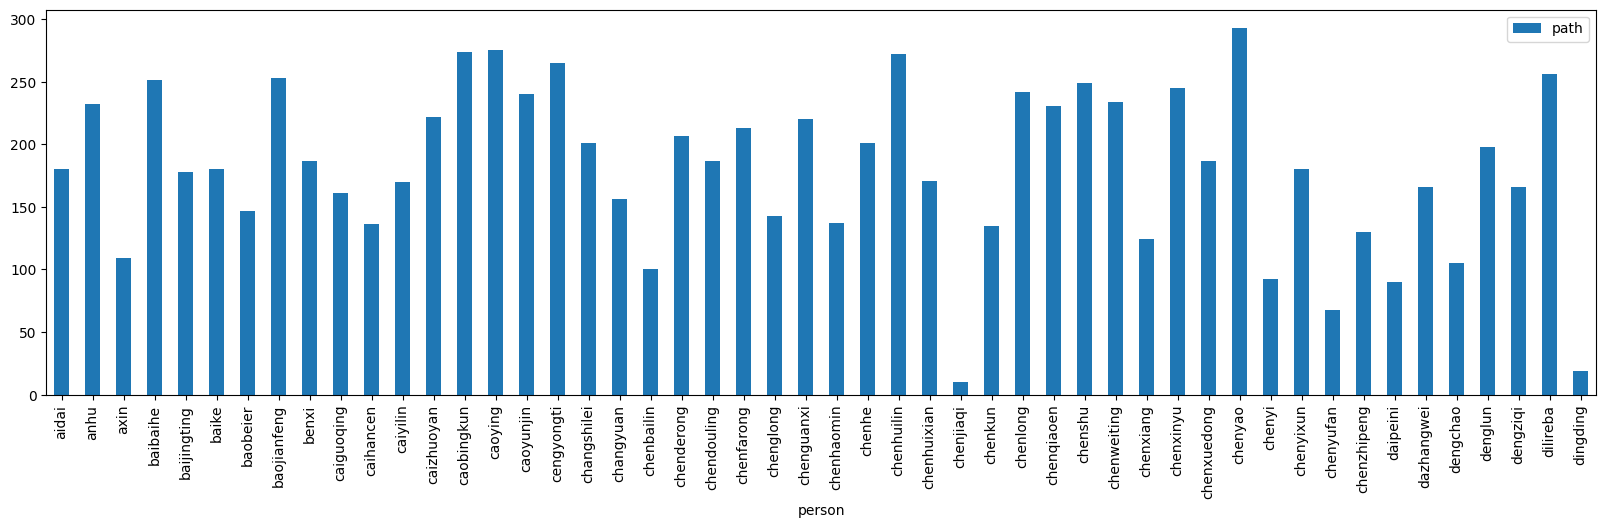

In [8]:
train.groupby("person").count()[:50].plot(kind='bar', figsize=(20,5))

In [9]:
print("number of person in train dataset : %s" %(len(train.groupby("person"))))
print("number of image in train dataset : %s" %(len(train)))

number of person in train dataset : 460
number of image in train dataset : 90468


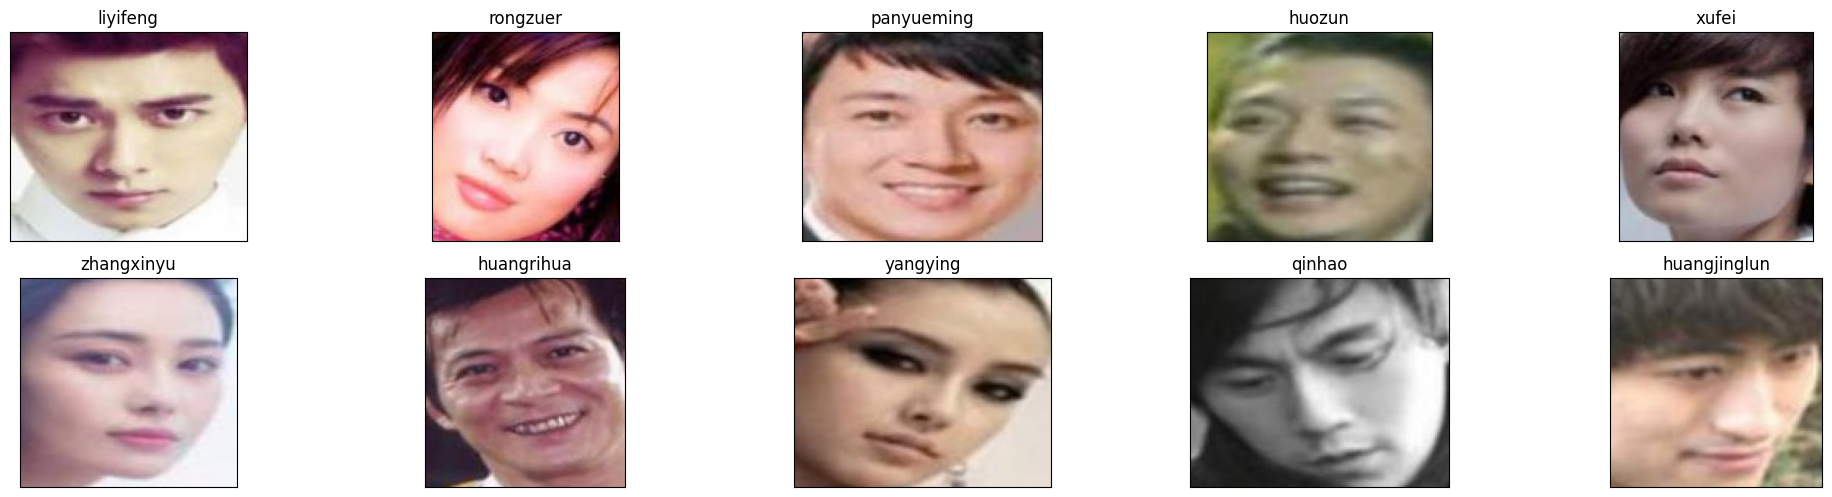

In [10]:
plt.figure(figsize=(20,10))
for i in range(10):
    idx = random.randint(0, len(train))
    img = plt.imread(train.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(train.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Test Dataset ##

In [11]:
test = []
for path in glob.iglob(os.path.join(test_path, "**", "*.jpg")):
    person = path.split("/")[-2]
    test.append({"person":person, "path": path})
test = pd.DataFrame(test)
test = test.groupby("person").filter(lambda x: len(x) > 0)
test.head(10)

,person,path
0,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...
1,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...
2,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...
3,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...
4,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...
5,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...
6,masichun,/kaggle/input/rmfd-dataset/self-built-masked-f...
7,wangzhen,/kaggle/input/rmfd-dataset/self-built-masked-f...
8,zhaojiamin,/kaggle/input/rmfd-dataset/self-built-masked-f...
9,zhaojiamin,/kaggle/input/rmfd-dataset/self-built-masked-f...


<Axes: xlabel='person'>

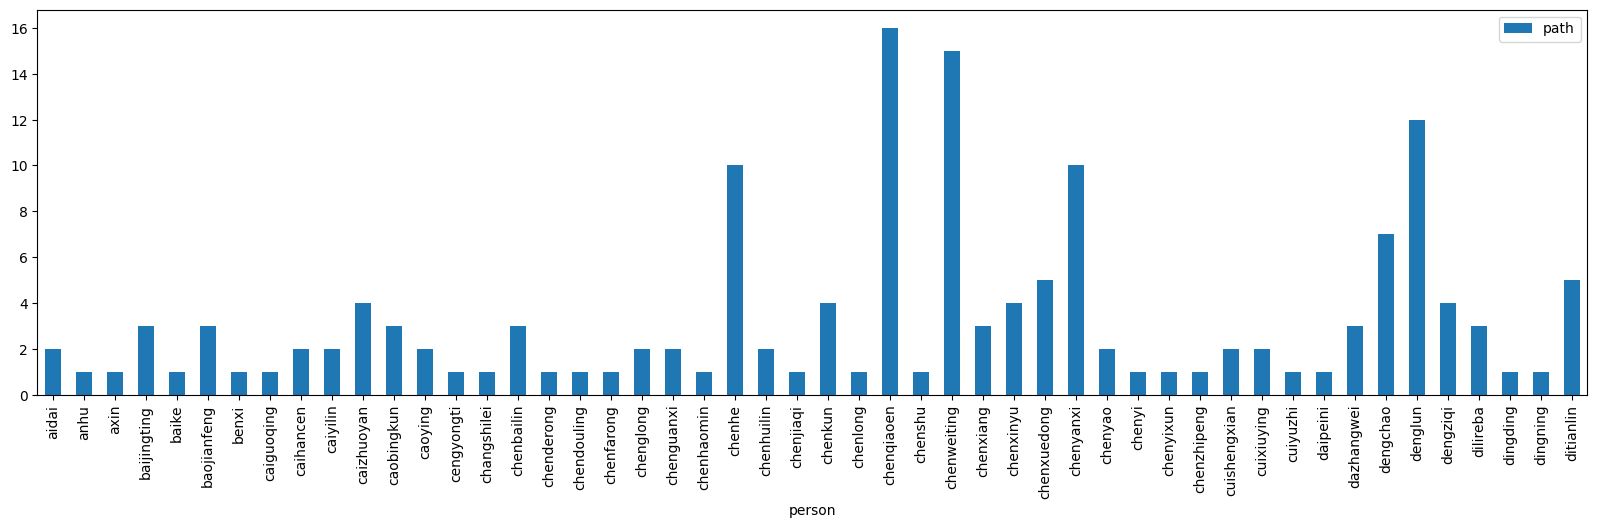

In [20]:
test.groupby("person").count()[:50].plot(kind='bar', figsize=(20,5))

In [21]:
print("number of person in test dataset : %s" %(len(test.groupby("person"))))
print("number of image in test dataset : %s" %(len(test)))

number of person in test dataset : 451
number of image in test dataset : 2118


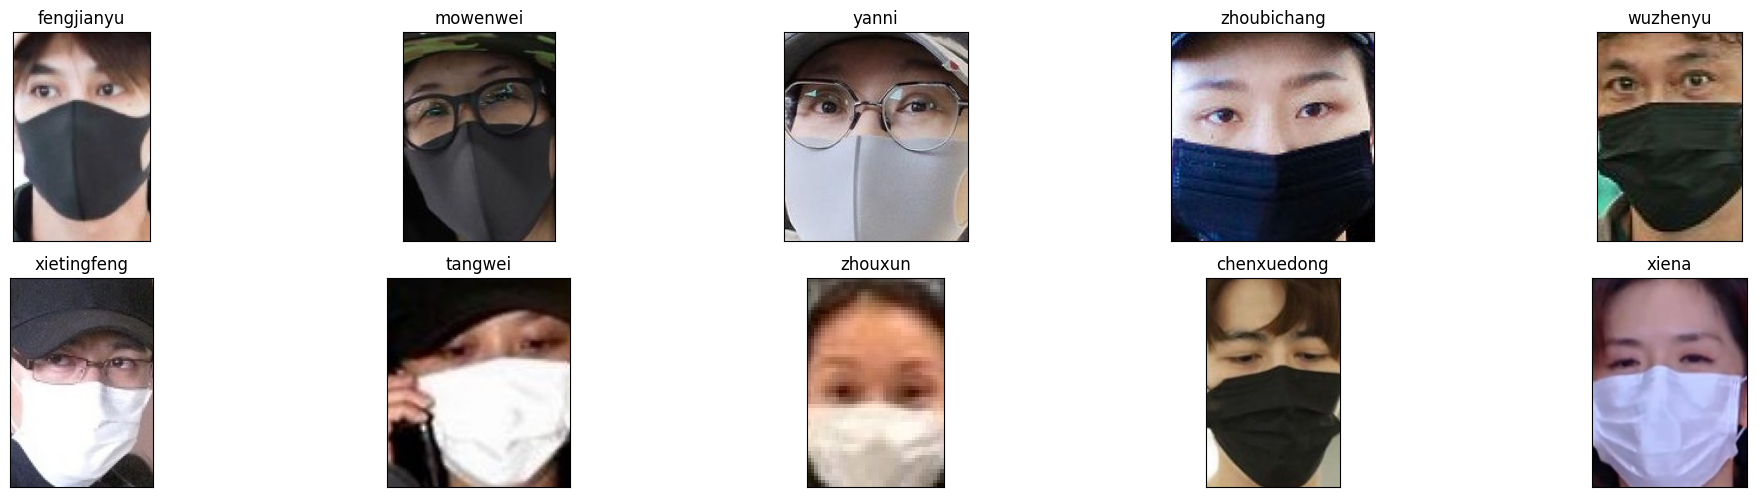

In [22]:
plt.figure(figsize=(20,10))
for i in range(10):
    idx = random.randint(0, len(test))
    img = plt.imread(test.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(test.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Size Of Train And Test ##

In [72]:
print("Train:",len(train))
print("Test:",len(test))

Train: 90468
Test: 2118


# Model #

In [12]:
IMG_SIZE = 112  # Standard size for most face recognition models
BATCH_SIZE = 128
NUM_WORKERS = 4  # Adjust based on your CPU
EPOCHS = 30
LEARNING_RATE = 0.0001
EMBEDDING_SIZE = 512
ARC_MARGIN = 0.5  # ArcFace margin
ARC_SCALE = 64.0  # ArcFace scale factor
NUM_IDENTITIES = None  # Will be set based on dataset

In [26]:
class FaceDataset(Dataset):
    def __init__(
        self,
        dataframe: pd.DataFrame,
        transform=None
    ):
        self.dataframe = dataframe
        self.transform = transform
        self.image_paths = dataframe['path'].values
        self.labels = dataframe['identity_id'].values
        
        logger.info(f"Created dataset with {len(self)} samples")
        # logger.info(f"Number of identities: {self.labels.nunique()}")

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]  
        
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            logger.error(f"Error loading image {img_path}: {e}")
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='gray')
        
        if self.transform:
            img = self.transform(img)
            
        return img, self.labels[idx]

def get_transforms():
    return transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def prepare_dataloaders(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    batch_size: int = BATCH_SIZE,
    num_workers: int = NUM_WORKERS
) -> Tuple[DataLoader, DataLoader, int]:
    train_ids, person_ids = pd.factorize(train_df['person'], sort=True)
    train_df['identity_id'] = train_ids
    num_classes = len(person_ids)

    test_df['identity_id'] = pd.Categorical(test_df['person'], categories=person_ids).codes
    invalid_test = test_df['identity_id'] == -1
    
    if invalid_test.any():
        logger.warning(f"Found {invalid_test.sum()} unknown identities in test set. Removing...")
        test_df = test_df[~invalid_test].copy()

    transform = get_transforms()

    train_dataset = FaceDataset(train_df, transform=transform)
    test_dataset = FaceDataset(test_df, transform=transform)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    logger.info(f"Train samples: {len(train_dataset)}")
    logger.info(f"Test samples: {len(test_dataset)}")
    logger.info(f"Number of identities: {num_classes}")

    return train_loader, test_loader, num_classes

In [14]:
class AttentionModule(nn.Module):
    """
    Spatial attention module that focuses on important regions of the face.
    Particularly useful for occluded faces where only parts of the face are visible.
    """
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels // 8, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Generate attention map
        attn = F.relu(self.conv1(x))
        attn = self.conv2(attn)
        attn = self.sigmoid(attn)
        
        # Apply attention
        out = x * attn 
        return out, attn

In [15]:
class UpperFaceAttention(nn.Module):
    """
    Specialized attention module that focuses on the upper face region 
    (eyes, forehead) which is often not occluded even when wearing masks.
    """
    def __init__(self, in_channels):
        super(UpperFaceAttention, self).__init__()
        self.attention = AttentionModule(in_channels)
        
        # Upper face bias - higher weights for upper half of feature maps
        self.register_buffer('spatial_bias', torch.ones(1, 1, IMG_SIZE // 8, IMG_SIZE // 8))
        h = self.spatial_bias.shape[2]
        # Set higher weight (1.5) for upper 60% of the face
        upper_region = int(0.6 * h)
        self.spatial_bias[0, 0, :upper_region, :] = 1.5
        
    def forward(self, x):
        # Apply general attention
        x, attn_map = self.attention(x)
        
        # Apply spatial bias (resized to match feature map dimensions)
        bias = F.interpolate(self.spatial_bias, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = x * bias
        
        return x, attn_map

In [16]:
class FaceRecognitionModel(nn.Module):
    """
    Face recognition model with attention mechanism focusing on the upper face.
    Uses a CNN backbone followed by an attention module.
    """
    def __init__(
        self, 
        num_classes: int, 
        embedding_size: int = EMBEDDING_SIZE,
        backbone_name: str = 'resnet50',
        pretrained: bool = True
    ):
        super(FaceRecognitionModel, self).__init__()
        
        # Initialize backbone CNN
        if backbone_name == 'resnet50':
            self.backbone = models.resnet50(pretrained=pretrained)
            self.backbone.fc = nn.Identity()  # Remove final FC layer
            self.feat_dim = 2048
        elif backbone_name == 'resnet34':
            self.backbone = models.resnet34(pretrained=pretrained)
            self.backbone.fc = nn.Identity()
            self.feat_dim = 512
        elif backbone_name == 'resnet18':
            self.backbone = models.resnet18(pretrained=pretrained)
            self.backbone.fc = nn.Identity()
            self.feat_dim = 512
        else:
            raise ValueError(f"Unsupported backbone: {backbone_name}")
        
        # Add attention module after layer3
        self.attention = UpperFaceAttention(self.backbone.layer3[-1].conv3.out_channels)
        
        # Embedding layer
        self.embedding = nn.Linear(self.feat_dim, embedding_size)
        
        # BatchNorm for embedding
        self.bn = nn.BatchNorm1d(embedding_size)
        
        # Initialize weights
        nn.init.kaiming_normal_(self.embedding.weight, mode='fan_out')
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)
        
        # Store model parameters
        self.num_classes = num_classes
        self.embedding_size = embedding_size
    
    def forward(self, x):
        # Get backbone features up to layer3
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        
        # Apply attention to focus on upper face
        x, attention_map = self.attention(x)
        
        # Continue with remaining backbone layers
        x = self.backbone.layer4(x)
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        
        # Get embedding
        embedding = self.embedding(x)
        embedding = self.bn(embedding)
        
        # Normalize embedding to unit length
        embedding = F.normalize(embedding, p=2, dim=1)
        
        return embedding, attention_map

In [17]:
class ArcFaceHead(nn.Module):
    """
    ArcFace head for face recognition.
    
    Reference:
    "ArcFace: Additive Angular Margin Loss for Deep Face Recognition"
    https://arxiv.org/abs/1801.07698
    """
    def __init__(
        self, 
        in_features: int, 
        out_features: int, 
        scale: float = ARC_SCALE, 
        margin: float = ARC_MARGIN
    ):
        super(ArcFaceHead, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        
        # Weight for the FC layer
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        
        # Make weights unit length
        self.weight.data = F.normalize(self.weight.data, p=2, dim=1)
        
        # Threshold for numerical stability
        self.threshold = math.pi - margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        # For numerical stability
        self.mm = math.sin(math.pi - margin) * margin
        
    def forward(self, embeddings, labels=None):
        # Normalize weights
        weights = F.normalize(self.weight, p=2, dim=1)
        
        # Compute cosine of angle between embeddings and weights
        cos_theta = F.linear(embeddings, weights)
        
        # Ensure values are in valid range [-1, 1]
        cos_theta = torch.clamp(cos_theta, -1.0, 1.0)
        
        if self.training and labels is not None:
            # For training with labels, apply ArcFace margin
            sin_theta = torch.sqrt(1.0 - torch.pow(cos_theta, 2))
            
            # Compute cos(theta + margin) using trigonometric formulas
            cos_theta_m = cos_theta * self.cos_m - sin_theta * self.sin_m
            
            # Handle theta + margin > pi case
            mask = cos_theta > self.threshold
            cos_theta_m[mask] = cos_theta[mask] - self.mm
            
            # One-hot encoding for labels
            one_hot = torch.zeros_like(cos_theta)
            one_hot.scatter_(1, labels.view(-1, 1), 1.0)
            
            # Apply margin only for the correct class
            output = torch.where(one_hot == 1, cos_theta_m, cos_theta)
            
            # Scale by s
            output = output * self.scale
        else:
            # For inference, just scale cosine similarity
            output = cos_theta * self.scale
            
        return output

In [18]:
class FaceRecognitionSystem(nn.Module):
    """
    Complete face recognition system combining backbone and ArcFace head.
    """
    def __init__(
        self, 
        num_classes: int, 
        embedding_size: int = EMBEDDING_SIZE,
        backbone_name: str = 'resnet50',
        pretrained: bool = True,
        arc_scale: float = ARC_SCALE,
        arc_margin: float = ARC_MARGIN
    ):
        super(FaceRecognitionSystem, self).__init__()
        
        # Face recognition model with attention
        self.face_model = FaceRecognitionModel(
            num_classes=num_classes,
            embedding_size=embedding_size,
            backbone_name=backbone_name,
            pretrained=pretrained
        )
        
        # ArcFace head
        self.arc_head = ArcFaceHead(
            in_features=embedding_size,
            out_features=num_classes,
            scale=arc_scale,
            margin=arc_margin
        )
        
    def forward(self, x, labels=None):
        # Get embeddings and attention map
        embeddings, attention_map = self.face_model(x)
        
        # Get ArcFace output
        if self.training and labels is not None:
            logits = self.arc_head(embeddings, labels)
        else:
            logits = self.arc_head(embeddings)
            
        return logits, embeddings, attention_map

In [19]:
def train_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
    epoch: int,
    scaler: Optional[GradScaler] = None
) -> Dict[str, float]:
    """
    Train for one epoch
    
    Args:
        model: Model to train
        train_loader: DataLoader for training data
        optimizer: Optimizer for training
        criterion: Loss function
        device: Device to train on
        epoch: Current epoch number
        scaler: Gradient scaler for mixed precision (optional)
        
    Returns:
        Dictionary with training metrics
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Mixed precision training if scaler is provided
        if scaler is not None:
            # with autocast():
            logits, embeddings, _ = model(inputs, targets)
            loss = criterion(logits, targets)
                
            # Scale gradients and optimize
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Regular training
            logits, embeddings, _ = model(inputs, targets)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
        
        # Update statistics
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = logits.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': running_loss / (batch_idx + 1),
            'acc': 100. * correct / total
        })
    
    # Calculate final metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    logger.info(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}%")
    
    return {'loss': epoch_loss, 'acc': epoch_acc}

In [20]:
def evaluate(
    model: nn.Module,
    test_loader: DataLoader,
    device: torch.device,
    save_embeddings: bool = False
) -> Dict[str, Union[float, np.ndarray]]:
    """
    Evaluate model on test data
    
    Args:
        model: Model to evaluate
        test_loader: DataLoader for test data
        device: Device to evaluate on
        save_embeddings: Whether to save embeddings for visualization
        
    Returns:
        Dictionary with evaluation metrics and optionally embeddings
    """
    model.eval()
    all_embeddings = []
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            logits, embeddings, _ = model(inputs)
            
            # Get predictions
            _, predicted = logits.max(1)
            
            # Store results
            all_embeddings.append(embeddings.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
            all_predictions.append(predicted.cpu().numpy())
    
    # Concatenate results
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)
    
    # Calculate accuracy
    accuracy = accuracy_score(all_targets, all_predictions)
    logger.info(f"test Accuracy: {accuracy*100:.2f}%")
    
    results = {
        'accuracy': accuracy,
    }
    
    # Save embeddings if requested
    if save_embeddings:
        results['embeddings'] = all_embeddings
        results['targets'] = all_targets
    
    return results

In [21]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler],
    criterion: nn.Module,
    device: torch.device,
    num_epochs: int,
    save_dir: str = './models',
    model_name: str = 'face_recognition',
    use_mixed_precision: bool = True,
    eval_every: int = 5
) -> Dict[str, List[float]]:
    """
    Train the model
    
    Args:
        model: Model to train
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        optimizer: Optimizer for training
        scheduler: Learning rate scheduler (optional)
        criterion: Loss function
        device: Device to train on
        num_epochs: Number of epochs to train for
        save_dir: Directory to save model checkpoints
        model_name: Name of the model for saving
        use_mixed_precision: Whether to use mixed precision training
        eval_every: Evaluate model every N epochs
        
    Returns:
        Dictionary with training history
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Initialize scaler for mixed precision
    scaler = GradScaler() if use_mixed_precision and torch.cuda.is_available() else None
    
    # Initialize history dictionary
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': [],
        'learning_rate': []
    }
    
    # Train for multiple epochs
    for epoch in range(num_epochs):
        # Record learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rate'].append(current_lr)
        logger.info(f"Epoch {epoch+1}/{num_epochs} | LR: {current_lr:.6f}")
        
        # Train for one epoch
        train_metrics = train_epoch(
            model=model,
            train_loader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            device=device,
            epoch=epoch,
            scaler=scaler
        )
        
        # Update history
        history['train_loss'].append(train_metrics['loss'])
        history['train_acc'].append(train_metrics['acc'])
        
        # Step scheduler
        if scheduler is not None:
            scheduler.step()
        
        # Evaluate model
        if (epoch + 1) % eval_every == 0 or epoch == num_epochs - 1:
            eval_metrics = evaluate(
                model=model,
                test_loader=test_loader,
                device=device,
                save_embeddings=(epoch == num_epochs - 1)  # Save embeddings on last epoch
            )
            
            history['test_acc'].append(eval_metrics['accuracy'])
            
            # Save embeddings for visualization
            if 'embeddings' in eval_metrics:
                np.save(
                    os.path.join(save_dir, f"{model_name}_embeddings.npy"), 
                    eval_metrics['embeddings']
                )
                np.save(
                    os.path.join(save_dir, f"{model_name}_targets.npy"), 
                    eval_metrics['targets']
                )
        
        # Save model checkpoint
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            torch.save(
                {
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                    'train_loss': train_metrics['loss'],
                    'train_acc': train_metrics['acc'],
                },
                os.path.join(save_dir, f"{model_name}_epoch{epoch+1}.pth")
            )
    
    # Save final model
    torch.save(
        model.state_dict(),
        os.path.join(save_dir, f"{model_name}_final.pth")
    )
    
    return history

In [22]:
def visualize_hardest_examples(
    model: nn.Module,
    test_loader: DataLoader,
    device: torch.device,
    save_dir: str = './visualizations',
    num_samples: int = 10
):
    """
    Visualize the hardest examples (most incorrect predictions)
    
    Args:
        model: Model to evaluate
        test_loader: DataLoader for test data
        device: Device to evaluate on
        save_dir: Directory to save visualizations
        num_samples: Number of samples to visualize
    """
    os.makedirs(save_dir, exist_ok=True)
    
    model.eval()
    incorrect_samples = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Finding hard examples"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            logits, _, _ = model(inputs)
            
            # Get predictions
            _, predicted = logits.max(1)
            
            # Find incorrect predictions
            incorrect_mask = ~predicted.eq(targets)
            incorrect_indices = torch.where(incorrect_mask)[0]
            
            for idx in incorrect_indices:
                confidence = F.softmax(logits[idx], dim=0)[predicted[idx]].item()
                incorrect_samples.append({
                    'input': inputs[idx].cpu(),
                    'target': targets[idx].item(),
                    'prediction': predicted[idx].item(),
                    'confidence': confidence
                })
    
    # Sort by confidence (higher confidence wrong predictions are harder)
    incorrect_samples.sort(key=lambda x: x['confidence'], reverse=True)
    
    # Limit number of samples
    incorrect_samples = incorrect_samples[:num_samples]
    
    # Visualize
    plt.figure(figsize=(15, 2 * num_samples))
    
    for i, sample in enumerate(incorrect_samples):
        # Denormalize image
        img = sample['input'].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        # Plot
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(img)
        plt.title(f"True: {sample['target']} | Predicted: {sample['prediction']} | Confidence: {sample['confidence']:.3f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'hardest_examples.png'))
    plt.close()
    
    logger.info(f"Hardest examples visualization saved")

# Main #

In [23]:
# Set hyperparameters
batch_size = 128
num_workers = 4
embedding_size = 512
backbone_name = 'resnet50'  # Options: 'resnet18', 'resnet34', 'resnet50'
num_epochs = 30
learning_rate = 0.0001
use_mixed_precision = True  # Use mixed precision training (faster on T4 GPUs)

In [24]:
save_dir = './models/arcface_recognition'
vis_dir = './visualizations/arcface_recognition'

os.makedirs(save_dir, exist_ok=True)
os.makedirs(vis_dir, exist_ok=True)

In [27]:
train_loader, test_loader, num_classes = prepare_dataloaders(train, test)

In [28]:
logger.info(f"Number of classes: {num_classes}")
    
# Create model
model = FaceRecognitionSystem(
    num_classes=num_classes,
    embedding_size=embedding_size,
    backbone_name=backbone_name,
    pretrained=True,
    arc_scale=64.0,
    arc_margin=0.5
)

# Move model to device
model = model.to(device)

# Use DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    logger.info(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

# Set up optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set up scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate/100)

# Set up loss function
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 106MB/s] 


In [29]:
# Train model
history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    device=device,
    num_epochs=num_epochs,
    save_dir=save_dir,
    model_name='arcface_face_recognition',
    use_mixed_precision=use_mixed_precision,
    eval_every=5
)

Epoch 1:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/707 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/707 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/707 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/707 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/707 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/707 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

In [30]:
visualize_hardest_examples(
    model=model,
    test_loader=test_loader,
    device=device,
    save_dir=vis_dir
)

Finding hard examples:   0%|          | 0/15 [00:00<?, ?it/s]

In [31]:
evaluate(model=model, test_loader=test_loader, device=device)

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

{'accuracy': 0.12667022982362372}

In [40]:
_, person_ids = pd.factorize(train['person'], sort=True)
class_names = person_ids.tolist()

In [41]:
print(class_names)

['aidai', 'anhu', 'axin', 'baibaihe', 'baijingting', 'baike', 'baobeier', 'baojianfeng', 'benxi', 'caiguoqing', 'caihancen', 'caiyilin', 'caizhuoyan', 'caobingkun', 'caoying', 'caoyunjin', 'cengyongti', 'changshilei', 'changyuan', 'chenbailin', 'chenderong', 'chendouling', 'chenfarong', 'chenglong', 'chenguanxi', 'chenhaomin', 'chenhe', 'chenhuilin', 'chenhuixian', 'chenjiaqi', 'chenkun', 'chenlong', 'chenqiaoen', 'chenshu', 'chenweiting', 'chenxiang', 'chenxinyu', 'chenxuedong', 'chenyao', 'chenyi', 'chenyixun', 'chenyufan', 'chenzhipeng', 'daipeini', 'dazhangwei', 'dengchao', 'denglun', 'dengziqi', 'dilireba', 'dingding', 'ditianlin', 'dongchengpeng', 'dongjie', 'dongxuan', 'duhaitao', 'dujiang', 'duwenze', 'fanbingbing', 'fanganna', 'fangzuming', 'fanshiqi', 'fanwei', 'fanyichen', 'fengjianyu', 'fuxinbo', 'ganwei', 'gaohu', 'gaoyixiang', 'gaoyuanyuan', 'gongbeibi', 'guanxiaotong', 'guanyue', 'gulinazha', 'guobiting', 'guofucheng', 'guojingfei', 'guojingjing', 'guojingming', 'guojunc

In [44]:
def visualize_random_predictions(
    model: torch.nn.Module,
    test_loader: DataLoader,
    device: torch.device,
    class_names: list,
    save_dir: str = './visualizations',
    n: int = 10
):
    """
    Predict and visualize random n images from the test set, showing class names.
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        device: Device (CPU or CUDA)
        class_names: List mapping class indices to class names
        save_dir: Directory to save visualizations
        n: Number of images to visualize
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    # Collect all samples into memory (only for visualization; okay for small test sets)
    all_samples = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits, _, _ = model(inputs)
            probs = F.softmax(logits, dim=1)
            confs, preds = probs.max(1)

            for i in range(inputs.size(0)):
                all_samples.append({
                    'input': inputs[i].cpu(),
                    'target': targets[i].item(),
                    'prediction': preds[i].item(),
                    'confidence': confs[i].item()
                })

    # Randomly sample N from collected predictions
    sampled = random.sample(all_samples, min(n, len(all_samples)))

    # Plotting
    plt.figure(figsize=(15, 2 * len(sampled)))
    for i, sample in enumerate(sampled):
        img = sample['input'].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        plt.subplot(len(sampled), 1, i + 1)
        plt.imshow(img)
        plt.title(
            f"True: {class_names[sample['target']]} | "
            f"Predicted: {class_names[sample['prediction']]} | "
            f"Confidence: {sample['confidence']:.3f}"
        )
        plt.axis('off')

    plt.tight_layout()
    # plt.savefig(os.path.join(save_dir, 'random_predictions.png'))
    # plt.close()

    # print(f"Saved visualization of {len(sampled)} random predictions to {save_dir}/random_predictions.png")


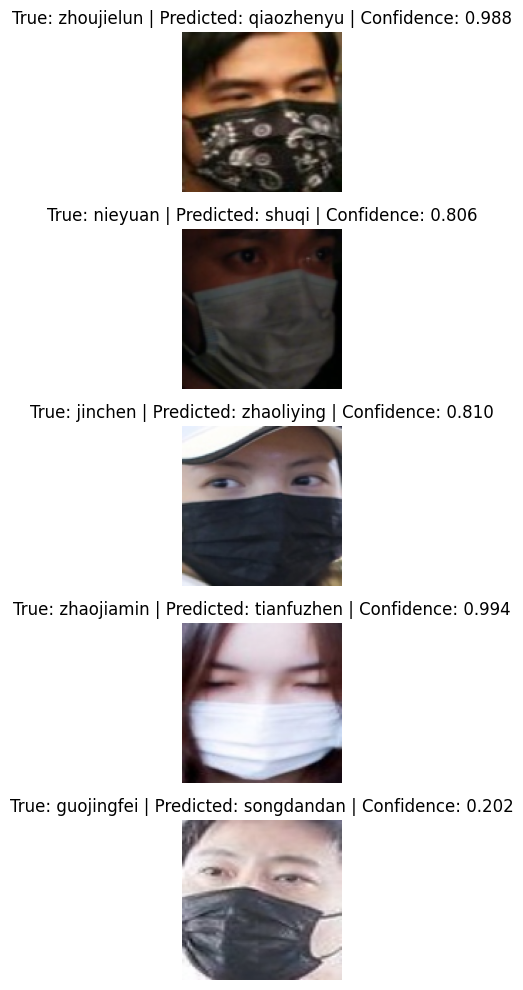

In [47]:
visualize_random_predictions(model=model,
    test_loader= test_loader,
    device=device,
    class_names=class_names,
    n = 5)